In [1]:

import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.dlpfc.basic2 import Basic2

from psychrnn.backend.dlpfc.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerDLPFC3 import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100
N_in = 3
N_out = 2


# Generate a batch of trials

In [3]:
task = Checkerboard2AFC(N_in = N_in, N_out = N_out, dt=dt, tau=tau, T=T, N_batch=N_batch, 
                        noise = 0.3, accumulation_mask = 0, wait = 0.2)

In [4]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 3,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [-0.9, 0.9],
 'side': 0.5,
 'noise': 0.3,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 0,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0}

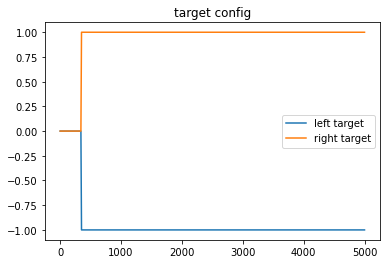

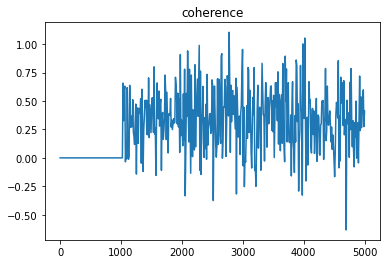

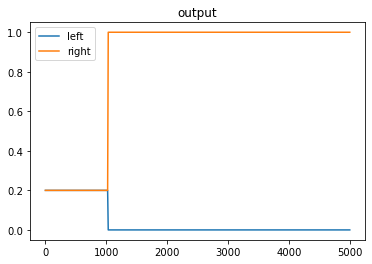

{'coherence': 0.3242557573338404, 'side': 0, 'noise': 0.3, 'accumulation_mask': 0, 'target_onset': 349, 'checker_onset': 672}


In [5]:
#### must check RT and time step 

[x, y, mask, allParams] = task.get_trial_batch()

trialNum = 5
# x[0]: left target 1: red; -1:green
# x[1]: right target 1: red; -1:green
# x[2]: color: -1: total green 1: total red
trialIn = x[trialNum,:,:]
trialOut = y[trialNum,:,:]
trialMask = mask[trialNum,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot target configuration (-1: red 1: green)
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left target')
plt.plot(time, trialIn[:,1], label = 'right target')
plt.legend()
plt.title("target config")

# plot input coherence (positive: red negative: green)
plt.figure()
plt.plot(time, trialIn[:,2])
plt.title("coherence")

# plot output to the model 
# y[0]: left evidence
# y[1]: right evidence
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()
plt.title("output")

# # plot trial masks
# # plt.figure()
# # plt.plot(time, trialMask[:,0])

plt.show()

# side: green side
# green_side = 0: left is green; x[0] = 1; x[1] = -1
# green_side = 1: right is green; x[0] = -1; x[1] = 1

print(allParams[trialNum])

# Set Network params

In [6]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.2

network_params["transfer_function"] = tf.nn.relu
# network_params["output_transfer_function"] = tf.nn.sigmoid
network_params["output_transfer_function"] = tf.nn.tanh

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07

# add a dale's ratio 
network_params['dale_ratio'] = .8



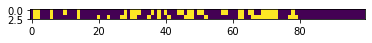

In [7]:
# add a input connectivity 
input_connectivity = np.zeros((N_rec, N_in))
# change connectivity 

# total number of target modulated 
Tnumbers = 30
Cnumbers = 30
overlap = 0.5
# Calculate the overlap size based on the desired percentage
overlap_size = int(Tnumbers * overlap)
# Generate the first set of random numbers (tar_units)
tar_units = np.random.choice(range(0, 80), size=Tnumbers, replace=False)
# Generate the second set of random numbers, excluding the overlapped numbers (color_units)
color_units = np.random.choice(np.setdiff1d(range(0, 80), tar_units[:overlap_size]), size=Cnumbers - overlap_size, replace=False)
# Combine the overlapped numbers from set1 with the non-overlapping numbers from set2
color_units = np.concatenate((color_units, tar_units[:overlap_size]))

# print("Set 1:", set1)
# print("Set 2:", set2)

# same_numbers_count = np.intersect1d(tar_units, color_units).size
# print("Number of same numbers:", same_numbers_count)


input_connectivity[tar_units,0] = 1
input_connectivity[tar_units,1] = 1

input_connectivity[color_units,2] = 1


network_params['input_connectivity'] = input_connectivity
plt.imshow(np.transpose(input_connectivity))

In [8]:
# target units
print(np.sort(tar_units))
# color units
print(np.sort(color_units))
# intersection of them
print(np.intersect1d(tar_units, color_units))
# union of target and color units
tar_color = np.union1d(tar_units, color_units)
print(tar_color)

[ 1  2  6 10 14 28 30 31 32 36 38 40 44 45 47 48 50 51 57 58 62 63 65 66
 69 70 71 72 73 78]
[ 1  2  6 14 20 23 27 28 30 31 35 38 41 46 47 48 52 62 63 66 67 68 69 70
 71 72 73 77 78 79]
[ 1  2  6 14 28 30 31 38 47 48 62 63 66 69 70 71 72 73 78]
[ 1  2  6 10 14 20 23 27 28 30 31 32 35 36 38 40 41 44 45 46 47 48 50 51
 52 57 58 62 63 65 66 67 68 69 70 71 72 73 77 78 79]


## add output connectivity: output units do not receive input

[ 0  1  2  3  7  9 10 13 18 21 26 28 29 33 34 38 39 40 43 44 46 48 49 51
 53 55 58 59 60 61 63 65 67 68 72 76]
[59 29 53 61 26 38 21 39  7 46  9 63 49 28 67  0 68 10 40 44  2 13 58 51
 43 34  3 60 65 18]


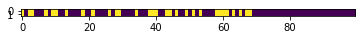

In [17]:
# Mnumbers = 30
# # all units that does not receive tar or color
# print(np.setdiff1d(range(0, 80), tar_color))
# # output units
# out_units = np.random.choice(np.setdiff1d(range(0, 80), tar_color), size = Mnumbers, replace=False)
# print(out_units)

# output_connectivity = np.zeros((N_out, N_rec))
# output_connectivity[0,out_units] = 1
# output_connectivity[1,out_units] = 1
# plt.imshow(output_connectivity)
# # modular_network_params['output_connectivity'] = output_connectivity

In [9]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)
model.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model.decision_threshold = network_params.get("decision_threshold", np.inf)

In [10]:
# check model
# vars(model)

# a = model.get_weights()
# a.keys()



## check all fields of model; check a tf variable

In [11]:
# store all model fields into a dict
modelParams = vars(model)
# get input connectivity 
conn = modelParams['input_connectivity']

# import tensorflow as tf
# #initialize the variable
# init_op = tf.initialize_all_variables()

# #run the graph
# with tf.Session() as sess:
#     sess.run(init_op) #execute init_op
#     #print the random values that we sample
#     print (sess.run(conn))
    
# sess.close() 

# Set Training params & Train

In [17]:
trials = 25000
train_params = {}
train_params['save_weights_path'] =  "./checkerDLPFC3TestfixedO"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None




#fixed output weights
# Set fixed weight matrices to the default
W_out_fixed = np.ones((N_out, N_rec))

b_out_fixed = np.ones(N_out)
# Specify the fixed weights parameters in train_params
train_params['fixed_weights'] = {
    'W_out': W_out_fixed,
    'b_out': b_out_fixed
}

In [18]:
train_params

{'save_weights_path': './checkerDLPFC3TestfixedO',
 'training_iters': 25000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'save_training_weights_epoch': 20.0,
 'training_weights_path': None,
 'fixed_weights': {'W_out': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.

In [19]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = "./checkerDLPFC3TestfixedO.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.135164
Iter 1000, Minibatch Loss= 0.176358
Iter 1500, Minibatch Loss= 0.190131
Iter 2000, Minibatch Loss= 0.127064
Iter 2500, Minibatch Loss= 0.074590
Iter 3000, Minibatch Loss= 0.096821
Iter 3500, Minibatch Loss= 0.067790
Iter 4000, Minibatch Loss= 0.088586
Iter 4500, Minibatch Loss= 0.073843
Iter 5000, Minibatch Loss= 0.052471
Iter 5500, Minibatch Loss= 0.051441
Iter 6000, Minibatch Loss= 0.053751
Iter 6500, Minibatch Loss= 0.048218
Iter 7000, Minibatch Loss= 0.069644
Iter 7500, Minibatch Loss= 0.040641
Iter 8000, Minibatch Loss= 0.053661
Iter 8500, Minibatch Loss= 0.036839
Iter 9000, Minibatch Loss= 0.047442
Iter 9500, Minibatch Loss= 0.038865
Iter 10000, Minibatch Loss= 0.041455
Iter 10500, Minibatch Loss= 0.044417
Iter 11000, Minibatch Loss= 0.037672
Iter 11500, Minibatch Loss= 0.044382
Iter 12000, Minibatch Loss= 0.050078
Iter 12500, Minibatch Loss= 0.047275
I

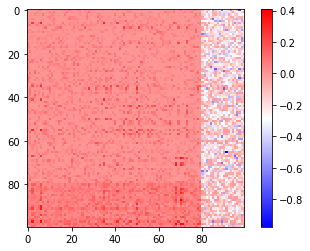

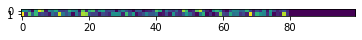

In [20]:
weights = model.get_weights()
W_rec = weights['W_rec']
plt.imshow(W_rec, cmap='bwr', interpolation='nearest')
# plt.imshow(W_rec)

plt.colorbar()
plt.show()

W_in = weights['W_in']
plt.imshow(W_in, cmap='bwr', interpolation='nearest')
plt.imshow(W_in)

W_out = weights['W_out']
plt.imshow(W_out, cmap='bwr', interpolation='nearest')
plt.imshow(W_out)

# plt.colorbar()
# plt.show()

In [32]:
weights


{'init_state': array([[ 0.03151232,  0.02091792,  0.00482884,  0.03855266,  0.05153055,
          0.03228211,  0.11220029,  0.07770944,  0.05510562,  0.02215736,
          0.02728282,  0.07101002,  0.04478577,  0.06280006,  0.05277803,
          0.05501399,  0.03608704,  0.14983052,  0.06647387,  0.04518453,
          0.16509145,  0.043965  ,  0.12627569,  0.03352939,  0.06078161,
          0.06222859,  0.06311847,  0.02698961,  0.03618855,  0.03084309,
          0.04531867,  0.04376847,  0.08286881,  0.03960707,  0.05369359,
         -0.0147609 ,  0.06939757,  0.06506245,  0.03012852,  0.05676483,
          0.07352023,  0.04725771,  0.00458778,  0.01737047,  0.03845035,
          0.04529181,  0.02334836,  0.05957466,  0.06852246,  0.04345289,
          0.03238669,  0.03464142,  0.03875786,  0.06658468,  0.05708493,
          0.06586951,  0.0385886 ,  0.01784883,  0.02365527,  0.04436393,
          0.05643394,  0.05393445,  0.04739235,  0.05501012,  0.06434168,
          0.04722112,  0

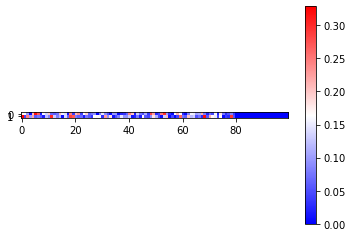

In [21]:
W_out = weights['W_out']
plt.imshow(W_out, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

# Test 5000 trials

In [22]:
trials =5000
batches = int(np.ceil(trials / N_batch))


rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

green_side = np.zeros(trials) 
coherence = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

correct_side = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)


In [23]:
for b in tqdm(range(batches)):
    [x, y, mask, params] = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    


    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        # configuration: green side
        green_side[index] = params[i]["side"]
        correct_side[index] = params[i]["side"] if params[i]["coherence"] < 0 else abs( params[i]["side"] - 1)
        
        
        ############ calculate RT and decision made 
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        
        # decision here: left: -1; right: 1; time out: 0
#         if (np.sum(outputs[i,:,0] > 0.7) != 0):
#             decision[index] = 0
#             temp = np.where(outputs[i,:,0] > 0.7)
#             rt[index] = temp[0][0]*task.dt - target_onset[index] - checker_onset[index] 
#         elif (np.sum(outputs[i,:,1] > 0.7) != 0):
#             decision[index] = 1
#             temp = np.where(outputs[i,:,1] > 0.7)
#             rt[index] = temp[0][0]*task.dt - target_onset[index] - checker_onset[index]             

#         else:
#             decision[index] = 2
#             rt[index] = T - target_onset[index] - checker_onset[index]

        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index] 


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


In [22]:
thr

(array([ 0,  1,  2,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,  7,  7,  8,  8,
         9, 10, 11, 12, 12, 13, 14, 14, 15, 15, 16, 16, 16, 17, 17, 18, 19,
        20, 20, 21, 22, 23, 24, 24, 25, 25, 25, 26, 27, 27, 28, 29, 29, 30,
        31, 33, 33, 33, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47,
        48, 49]),
 array([101, 126,  99,  83, 130, 131, 161, 162, 163, 168, 169,  99, 100,
        101, 102, 270, 271, 154, 306,  46, 122, 123, 101, 171, 172, 152,
        153, 198, 199, 200, 187, 188, 160, 156, 185, 186, 150, 115,  77,
        170, 171, 137, 138, 141, 186, 151, 152, 292, 154, 155, 171, 289,
        122, 123, 124, 125, 156, 122, 104, 396,  70, 292, 119, 148, 138,
        363, 242, 104, 132, 112]),
 array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0]))

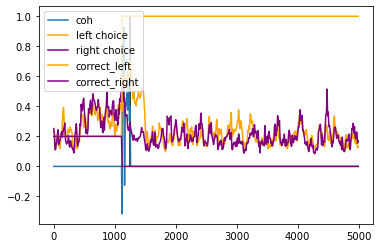

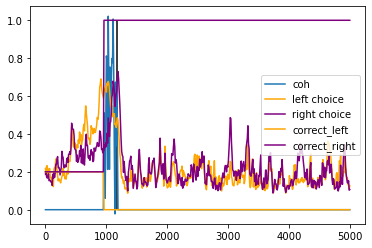

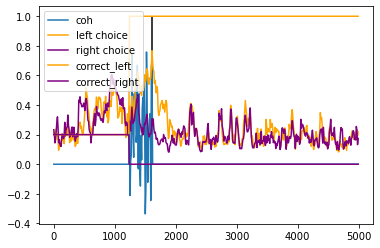

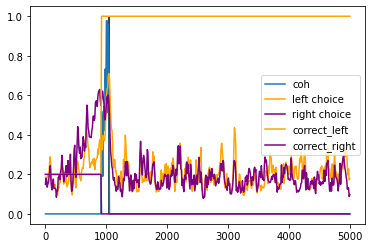

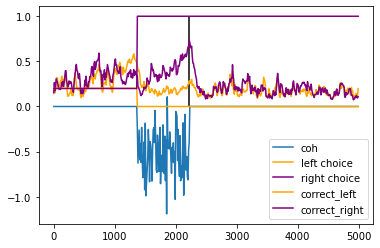

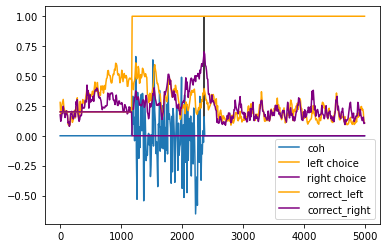

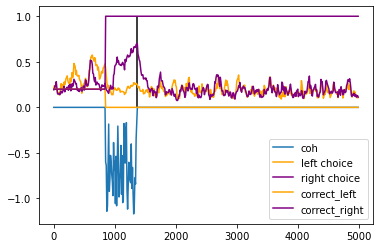

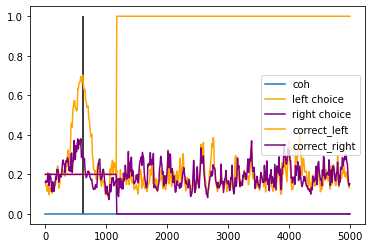

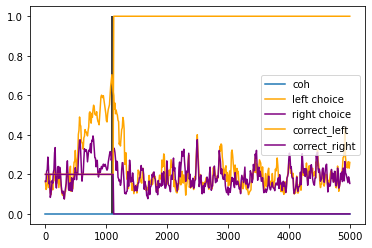

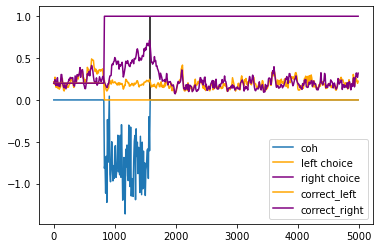

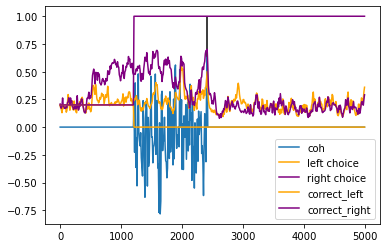

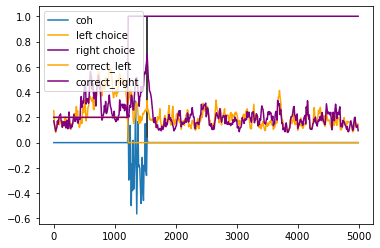

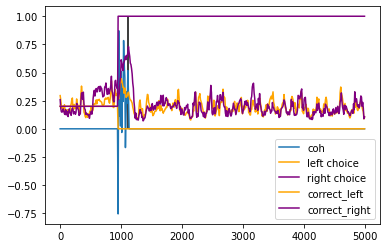

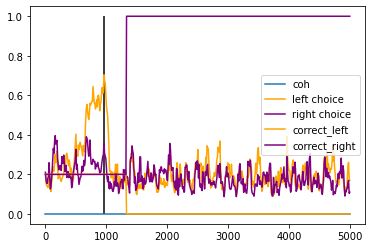

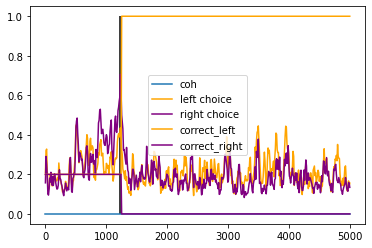

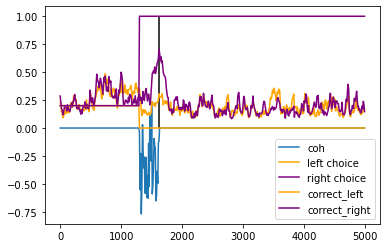

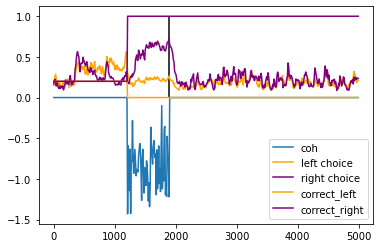

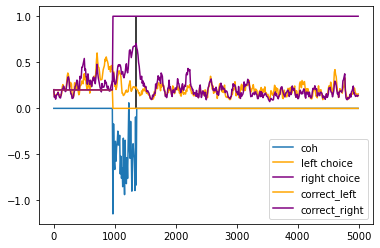

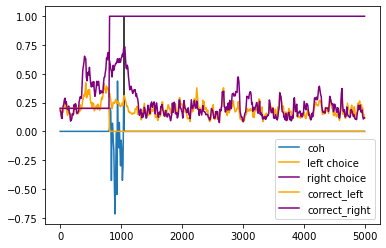

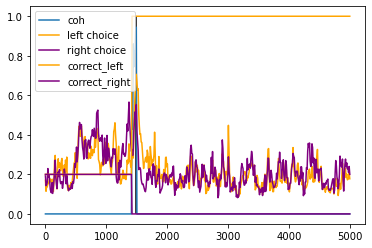

In [24]:
# plot example trials
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(0,20):
    plt.figure()
#     plt.plot(np.arange(0, T, 10), inputs[i, :, 0], label = 'config')
    plt.plot(np.arange(0, T, 10), inputs[i, :, 2], label = 'coh')

    plt.plot(np.arange(0, T, 10), outputs[i, :, 0], label = 'left choice', color = 'orange')
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1], label = 'right choice', color = 'purple')    
    plt.plot(np.arange(0, T, 10), y[i, :, 0], label = 'correct_left', color = 'orange')
    plt.plot(np.arange(0, T, 10), y[i, :, 1], label = 'correct_right', color = 'purple')
    plt.legend()
    
    
#     plt.vlines(onsets[i], 0, 1, color = 'k')
    plt.vlines(onsets[i] + rts[i], 0, 1, color = 'k')
#     plt.figure()
#     plt.plot(np.arange(0, T, 10), g[i])

In [25]:

checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           # the real coherence based on left and right (positive: left evidence dominant
                           # negative: right evidence dominant)
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int),
                          'green_side' : green_side})



print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
print("Negative RT trials ratio: ", end = "")
print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))



Overall Accuracy: 0.831
Negative RT trials ratio: 0.2042


In [30]:
# checker_df


# only the behavior results dataframe has this
# chosen color: 1 (red); 0 (green)
# all other setup has 
# chosen color: 1 (red); -1 (green)

chosen_color = np.zeros([len(checker_df),1])
for i in range(len(checker_df)):
    if(checker_df.green_side[i] == 0 and checker_df.decision[i] == 0):
        chosen_color[i] = 0
    if(checker_df.green_side[i] == 0 and checker_df.decision[i] == 1):
        chosen_color[i] = 1        
    if(checker_df.green_side[i] == 1 and checker_df.decision[i] == 1):  
        chosen_color[i] = 0        
    if(checker_df.green_side[i] == 1 and checker_df.decision[i] == 0):        
        chosen_color[i] = 1        
        
checker_df["chosen_color"] = chosen_color

checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


#######################
## summary result save path

resultPath = "./checkerDLPFC3TestfixedO.csv"
checker_df.to_csv(resultPath)

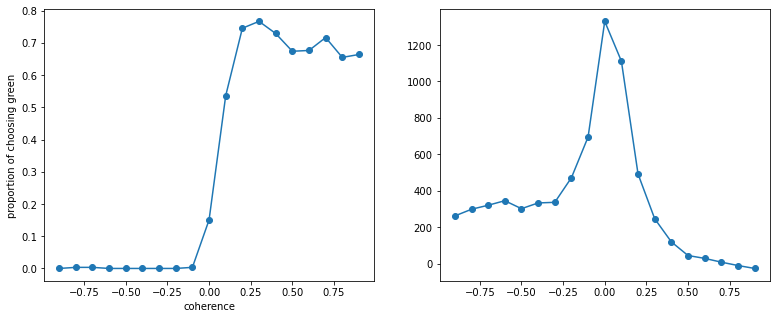

In [27]:
# psychrometric curve 
plt.figure(figsize=(13, 5))
plt.subplot(1,2,1)
plt.plot(checker_mean['coherence_bin'], checker_mean['chosen_color'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['chosen_color'])
plt.xlabel("coherence")
plt.ylabel("proportion of choosing green")
plt.subplot(1,2,2)
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])



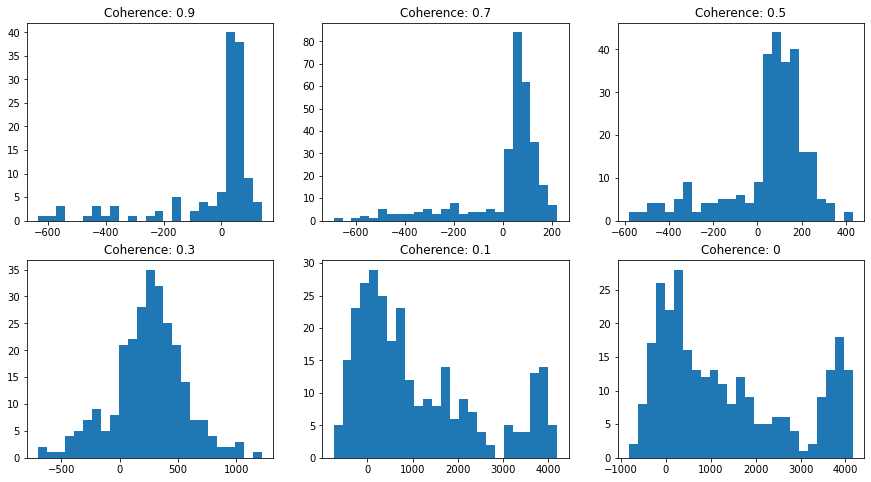

In [28]:
idx = 1
plt.figure(figsize=(15, 8))
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.subplot(2,3,idx)
    plt.hist(RT, bins = 25)
    plt.title("Coherence: " + str(i))
    idx = idx + 1

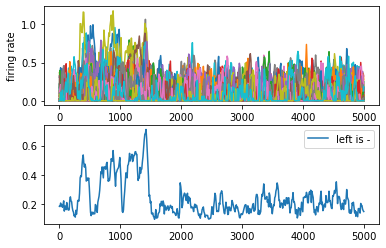

In [28]:
trial_num = 50
plt.figure()
plt.subplot(211)
_ = plt.plot(np.arange(0, T, dt), rnn_state[trial_num,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(np.arange(0, T, dt), rnn_out[trial_num,:,0], label = "left is -")
plt.legend()

In [29]:
# transpose the data and save as .mat file for analysis on matlab
temp = np.transpose(rnn_state, (2,1,0))
from scipy.io import savemat
mdic = {'temp': temp}
savemat("fixedO.mat", mdic)

In [1]:
model.destruct()

NameError: name 'model' is not defined